# Credit Cards - Predicition of churning customers

#### Step by step guide to create a Random Forest Classifier to predict the Customer Churning

1. Data Understanding
2. Data Preparation
3. Feature Engineering
4. Feature Extraction
5. Training
6. Evaluation

# Data Understanding

**Importing the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

**Loading the dataset**

In [2]:
path = '/kaggle/input/credit-card-customers/'

data = pd.read_csv(path + 'BankChurners.csv')

# drop last two columns
data = data.iloc[:, :-2]
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


**Preliminary Data Description**

In [3]:
print(f"""
    No. of samples  : {data.shape[0]}
    No. of features : {data.shape[1]}
    Missing values  : {data.isnull().sum().sum()}
""")


    No. of samples  : 10127
    No. of features : 21
    Missing values  : 0



# Data Preparation

**Categorical features present in the dataset**

In [4]:
data.select_dtypes(include='object').columns.to_list()

['Attrition_Flag',
 'Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

**Label Encoding the ordinal features**

In [5]:
data['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1}, inplace=True)

data['Gender'].replace({'M': 1, 'F': 0})

education_mapping = {
    'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3, 
    'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6
}
data['Education_Level'].replace(education_mapping, inplace=True)

income_mapping= {
    'Less than $40K': 'less_than_40k', '$40K - $60K': '40k_60k', '$60K - $80K': '60k_80k', 
    '$80K - $120K': '80k_120k', '$120K +': 'greater_than_120k',
}
data['Income_Category'].replace(income_mapping, inplace=True)

**One-Hot encoding the nominal features**

In [6]:
data_dummies = pd.get_dummies(data)

**Drop the below features**

1. `CLIENTNUM` - Since, it is an ID parameter and not relevant for our analysis
2. We can drop one feature from each of the `one-hot encoded` features. In our case, we are dropping -
    * `Gender_F`
    * `Marital_Status_Unknown`
    * `Income_Category_Unknown`

In [7]:
data.drop('CLIENTNUM', axis=1, inplace=True)

data_dummies.drop(['Gender_F', 'Marital_Status_Unknown', 'Income_Category_Unknown'], axis=1, inplace=True)

**Dataset description after data preparation**

In [8]:
print(f"""
    No. of samples  : {data.shape[0]}
    No. of features : {data.shape[1]}
    Missing values  : {data.isnull().sum().sum()}
""")


    No. of samples  : 10127
    No. of features : 20
    Missing values  : 0



# Feature Engineering

**Checking `skewness` of the numeric features**

In [9]:
df_skew = pd.DataFrame(data_dummies.skew(), columns=['Skewness']).sort_values(by='Skewness')
df_skew.head()

,Skewness
Card_Category_Blue,-3.425241
Total_Relationship_Count,-0.162452
Total_Revolving_Bal,-0.148837
Months_on_book,-0.106565
Customer_Age,-0.033605


**Applying `log transformation` to the highly skewed features**

In [10]:
## Get all the numeric features in out dataset
numeric_features = data_dummies.skew().index

## We do not want to touch our target feature
if 'Attrition_Flag' in numeric_features:
    numeric_features = numeric_features.drop('Attrition_Flag')
    
## Getting all the skewed features (skew > 0.5 or skew < -0.5)
skewed_features = data_dummies[numeric_features].skew()[np.abs(data_dummies[numeric_features].skew()) > 0.5].index

## Performing log(1+x) transformation
data_dummies[skewed_features] = np.log1p(data_dummies[skewed_features])

**Check the correlation among features using the heatmap**

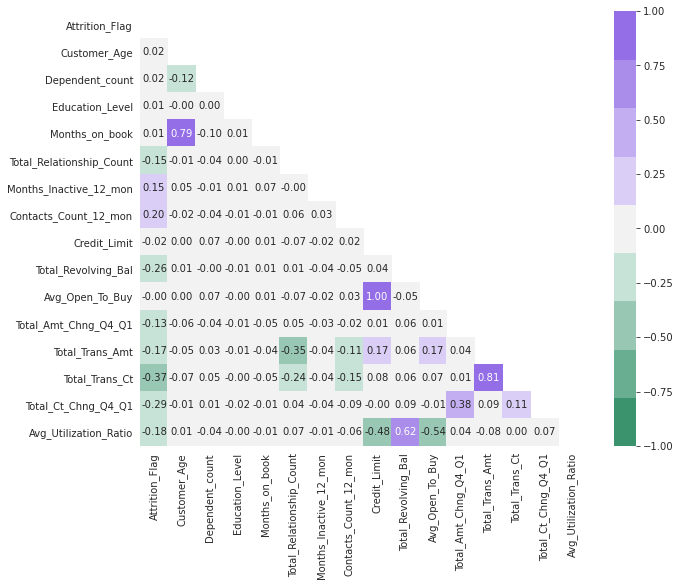

In [11]:
# Get the correlation dataframe
df_corr = data.corr()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask    = np.triu(np.ones_like(df_corr, dtype=np.bool))
sns.heatmap(
    df_corr, mask=mask, annot=True, fmt=".2f", vmin = -1, vmax = 1,
    cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9)
)
plt.show()

# Feature Extraction

In [12]:
# Separate the independent and dependent variable
X = data_dummies.drop("Attrition_Flag", axis = 1)
y = data_dummies["Attrition_Flag"]

# Get the training and testing pairs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Chi Square test for feature extraction**

[Reference link](https://machinelearningmastery.com/feature-selection-with-categorical-data/)

Feature 0: 0.001804
Feature 1: 2.290876
Feature 2: 1.925850
Feature 3: 2.703568
Feature 4: 1.479657
Feature 5: 121.643257
Feature 6: 15.426591
Feature 7: 156.905458
Feature 8: 1.122552
Feature 9: 283133.029580
Feature 10: 0.511333
Feature 11: 3.203404
Feature 12: 19.158509
Feature 13: 8400.319965
Feature 14: 25.160248
Feature 15: 50.887066
Feature 16: 4.095562
Feature 17: 0.046801
Feature 18: 2.434682
Feature 19: 1.851978
Feature 20: 0.083759
Feature 21: 3.955761
Feature 22: 0.001324
Feature 23: 1.235685
Feature 24: 0.645130
Feature 25: 0.004208
Feature 26: 0.679307
Feature 27: 1.865958
Feature 28: 0.144238


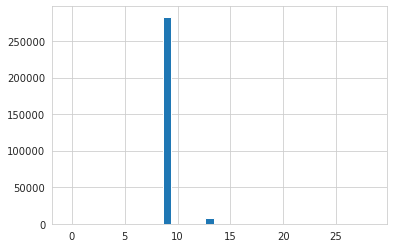

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

The above results give us the feature index value and their corresponding importance. Higher the value, more important the feature is.

In [14]:
X_train = X_train.iloc[:, [5, 6, 7, 9, 12, 13, 14, 15]]
X_test = X_test.iloc[:, [5, 6, 7, 9, 12, 13, 14, 15]]

# Training

**Using strong ensemble model classifier - Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluation

**Confusion Matrix**

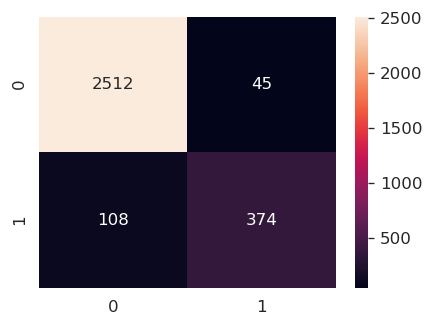

In [16]:
from sklearn.metrics import confusion_matrix

arr_cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(arr_cm, index=[0, 1], columns=[0, 1])
fig = plt.figure(figsize=(4,3), dpi=120)
sns.heatmap(df_cm, annot=True, fmt="d")
plt.show()

**Classification Report**

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2557
           1       0.89      0.78      0.83       482

    accuracy                           0.95      3039
   macro avg       0.93      0.88      0.90      3039
weighted avg       0.95      0.95      0.95      3039



**Accuracy Score**

In [18]:
print('Model Accuracy:', round(accuracy_score(y_test, y_pred)*100, 3), '%')

Model Accuracy: 94.965 %
